# XGBOOST - PREDICT cases

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('bmh')

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error

In [2]:
# read in pickled features
df_sj = pd.read_pickle('./datasets/all_sj.pkl')
df_iq = pd.read_pickle('./datasets/all_iq.pkl')

total_cases = pd.read_csv('./datasets/dengue_labels_train.csv')
cases_sj = total_cases[total_cases['city'] == 'sj']['total_cases']
cases_iq = total_cases[total_cases['city'] == 'iq']['total_cases']

# create month variable
df_sj['month'] = df_sj.index.month
df_iq['month'] = df_iq.index.month

# create mean ndvi
df_sj['ndvi_mean'] = (df_sj['ndvi_ne'] + df_sj['ndvi_nw'] + df_sj['ndvi_se'] + df_sj['ndvi_sw']) / 4.0
df_iq['ndvi_mean'] = (df_iq['ndvi_ne'] + df_iq['ndvi_nw'] + df_iq['ndvi_se'] + df_iq['ndvi_sw']) / 4.0

## Train-Validation-Test Split
Because this is time-series data and the features set is dependent on the past, the train test split is very delicate. The validation and test feature set will actually draw from data in the past (rolling mean, std, etc.). Therefore, when creating the model, the entire dataset must be used. But I must be careful not to train the model on data from the 'future'.

In [3]:
# train test split
#sj

# choose split dates
sj_valid_split = '2003-4-20'
sj_test_split = '2008-4-27' # this will split between pre and post submission dates

# split into train, valid, test (no y)
sj_train = df_sj.loc[:sj_valid_split]
sj_Xtrain = sj_train
sj_ytrain = cases_sj[:len(sj_train)]

sj_valid = df_sj.loc[sj_valid_split : sj_test_split]
sj_Xvalid = sj_valid
sj_yvalid = cases_sj[len(sj_train):]

sj_test = df_sj.loc[sj_test_split:]
sj_Xtest = sj_test

print len(sj_train), len(sj_Xtrain), len(sj_ytrain)
print len(sj_valid), len(sj_Xvalid), len(sj_yvalid)
print len(sj_test), len(sj_Xtest)

675 675 675
261 261 261
260 260


In [4]:
#iq

# choose split dates
iq_valid_split = '2007-7-01'
iq_test_split = '2010-7-01' # this will split between pre and post submission dates

# split
iq_train = df_iq.loc[:iq_valid_split]
iq_Xtrain = iq_train
iq_ytrain = cases_iq[:len(iq_Xtrain)]

iq_valid = df_iq.loc[iq_valid_split : iq_test_split]
iq_Xvalid = iq_valid
iq_yvalid = cases_iq[len(iq_train):]

iq_test = df_iq.loc[iq_test_split:]
iq_Xtest = iq_test

# check the lengths
print len(iq_train), len(iq_Xtrain), len(iq_ytrain)
print len(iq_valid), len(iq_Xvalid), len(iq_yvalid)
print len(iq_test), len(iq_Xtest)

364 364 364
156 156 156
156 156


## Test XGBoost GridSearch on validation data

In [5]:
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV

In [32]:
#set up training data
months = pd.get_dummies(sj_Xtrain['month'], prefix='month')
weather = sj_Xtrain.drop(['month', 'weekofyear'], axis = 1)
weather2 = weather.rolling(window = 53, min_periods=1).mean()
weather2.columns = [str(i) + '_2' for i in weather2.columns]
train = pd.concat([months, weather, weather2], axis = 1)

In [42]:
# grid search for best fit

params = {  
    "booster" : ('gblinear', 'gbtree'), 
    "n_estimators": [10, 200],
    "max_depth": [12, 15],
    "learning_rate": np.linspace(0.05, 0.3, 4),
    "min_child_weight": (4, 6)
}

xgbreg = XGBRegressor()

gs = GridSearchCV(xgbreg, params, n_jobs=1, verbose = 1)  
gs.fit(train, sj_ytrain)  
gs.best_estimator_

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=1)]: Done 192 out of 192 | elapsed:   58.3s finished


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.050000000000000003,
       max_delta_step=0, max_depth=12, min_child_weight=6, missing=None,
       n_estimators=10, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

18.3853676913
0.00587746736777


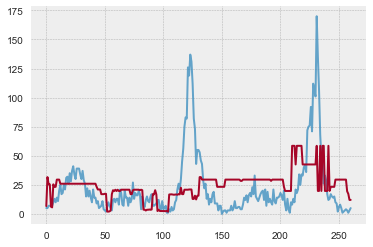

In [43]:
months = pd.get_dummies(sj_Xvalid['month'], prefix='month')
weather = sj_Xvalid.drop(['month', 'weekofyear'], axis = 1)
weather2 = weather.rolling(window = 53, min_periods=1).mean()
weather2.columns = [str(i) + '_2' for i in weather2.columns]
valid = pd.concat([months, weather, weather2], axis = 1)

# make and plot predictions, scores
preds = pd.Series(gs.predict(valid))
# preds = preds.rolling(2, min_periods=1, center = True).mean()
plt.plot(sj_yvalid.values, alpha = .75)
plt.plot(preds)
print mean_absolute_error(preds, sj_yvalid.values)
print gs.score(valid, sj_yvalid)

### XGBoost to predict test data

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=1)]: Done 192 out of 192 | elapsed:  1.4min finished


0.116478965382


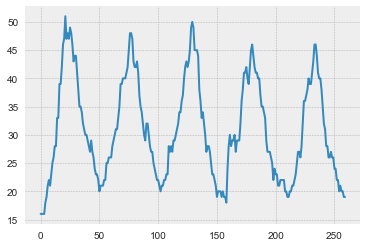

In [45]:
#set up training data
sj_Xtrain2 = pd.concat([sj_Xtrain, sj_Xvalid], axis = 0)
sj_ytrain2 = pd.concat([sj_ytrain, sj_yvalid], axis = 0)
months = pd.get_dummies(sj_Xtrain2['month'], prefix='month')
weather = sj_Xtrain2.drop(['month', 'weekofyear'], axis = 1)
weather2 = weather.rolling(window = 53, min_periods=1).mean()
weather2.columns = [str(i) + '_2' for i in weather2.columns]
train = pd.concat([months, weather, weather2], axis = 1)

# grid search for best fit

params = {  
    "booster" : ('gblinear', 'gbtree'), 
    "n_estimators": [10, 200],
    "max_depth": [12, 15],
    "learning_rate": np.linspace(0.05, 0.3, 4),
    "min_child_weight": (4, 6)
}

xgbreg = XGBRegressor()

gs = GridSearchCV(xgbreg, params, n_jobs=1, verbose = 1)  
gs.fit(train, sj_ytrain2)  
gs.best_estimator_

months = pd.get_dummies(sj_Xtest['month'], prefix='month')
weather = sj_Xtest.drop(['month', 'weekofyear'], axis = 1)
weather2 = weather.rolling(window = 53, min_periods=1).mean()
weather2.columns = [str(i) + '_2' for i in weather2.columns]
test = pd.concat([months, weather, weather2], axis = 1)

# make predictions
sj_preds = pd.Series(gs.predict(test))
sj_preds = sj_preds.rolling(3, min_periods=1).mean().apply(lambda x: int(x))

# plot
plt.plot(sj_preds)
print gs.score(train, sj_ytrain2)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=1)]: Done 192 out of 192 | elapsed:   41.9s finished


0.197958096806


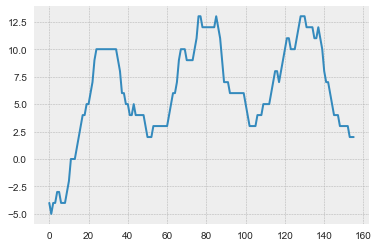

In [46]:
#set up training data
iq_Xtrain2 = pd.concat([iq_Xtrain, iq_Xvalid], axis = 0)
iq_ytrain2 = pd.concat([iq_ytrain, iq_yvalid], axis = 0)
months = pd.get_dummies(iq_Xtrain2['month'], prefix='month')
weather = iq_Xtrain2.drop(['month', 'weekofyear'], axis = 1)
weather2 = weather.rolling(window = 53, min_periods=1).mean()
weather2.columns = [str(i) + '_2' for i in weather2.columns]
train = pd.concat([months, weather, weather2], axis = 1)

# grid search for best fit

params = {  
    "booster" : ('gblinear', 'gbtree'), 
    "n_estimators": [10, 200],
    "max_depth": [12, 15],
    "learning_rate": np.linspace(0.05, 0.3, 4),
    "min_child_weight": (4, 6)
}

xgbreg = XGBRegressor()

gs = GridSearchCV(xgbreg, params, n_jobs=1, verbose = 1)  
gs.fit(train, iq_ytrain2)  
gs.best_estimator_

months = pd.get_dummies(iq_Xtest['month'], prefix='month')
weather = iq_Xtest.drop(['month', 'weekofyear'], axis = 1)
weather2 = weather.rolling(window = 53, min_periods=1).mean()
weather2.columns = [str(i) + '_2' for i in weather2.columns]
test = pd.concat([months, weather, weather2], axis = 1)

# make predictions
iq_preds = pd.Series(gs.predict(test))
iq_preds = iq_preds.rolling(3, min_periods=1).mean().apply(lambda x: int(x))

# plot
plt.plot(iq_preds)
print gs.score(train, iq_ytrain2)

In [47]:
## combine predictions in submission

In [50]:
all_preds = pd.concat([sj_preds, iq_preds], axis = 0).reset_index(drop=True)

# import submission
submission_format = pd.read_csv('./datasets/submission_format.csv')
submission_format['total_cases'] = all_preds

# Save to CSV, use current date
submission_format.to_csv('submissions/dengue_submission_9_18_17v1.csv', index=False)

In [51]:
submission_format.head()

,city,year,weekofyear,total_cases
0,sj,2008,18,16
1,sj,2008,19,16
2,sj,2008,20,16
3,sj,2008,21,16
4,sj,2008,22,18


### Submitted to DataDriven:
* First MAE = 27.37
* Second MAE = 26.07
* Not good